In [300]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from scipy.stats import randint, uniform

In [301]:
raw_car_data = pd.read_csv('data/all_car_adverts.csv', index_col=0)

In [302]:
pd.set_option('display.max_columns', None)
raw_car_data.head()

,make,model,variant,car_price,car_badges,car_title,car_sub_title,car_attention_grabber,car_specs,car_seller,car_seller_rating,car_seller_location,year,reg,body_type,miles,engine_vol,engine_size,engine_size_unit,transmission,feul_type,num_owner,ulez,full_service,part_service,part_warranty,full_dealership,first_year_road_tax,brand_new,finance_available,discounted
0,AC,Cobra,NaN,89995.0,NaN,AC Cobra,4.9 MK IV CRS 2dr,GENUINE AC COBRA CRS 522 BHP,"2001 (X reg), Convertible, 14,400 miles, 4.9L,...",Private seller,NaN,watford,2001,X reg,convertible,14400.0,4.9,225.0,bhp,manual,petrol,5.0,0,0,0,0,0,0,0,0,0
1,AC,Cobra,NaN,92500.0,'',AC Cobra,378 - MkIV,PHYSICAL CAR!,"2019 (T reg), Convertible, 650 miles, Manual, ...",Boss Motor Company Limited,5.0,chesham,2019,T reg,convertible,650.0,NaN,NaN,NaN,manual,petrol,NaN,0,0,0,0,0,0,0,0,0
2,AC,Cobra,NaN,109995.0,'',AC Cobra,MK1V 212 SC. 3.5 V8 350 BHP LOTUS TWIN TURBO. ...,FULL CARBON FIBRE BODY.,"2000 (X reg), Convertible, 21,600 miles, 3.5L,...",PREMIER GT LIMITED,4.8,pulborough,2000,X reg,convertible,21600.0,3.5,NaN,NaN,manual,petrol,3.0,0,0,0,0,0,0,0,0,0
3,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV 2dr,ABSOLUTELY STUNNING,"1989 (F reg), Convertible, 2,750 miles, Manual...",TOP 555 LIMITED,5.0,oakham,1989,F reg,convertible,2750.0,NaN,NaN,NaN,manual,petrol,NaN,0,0,0,0,0,0,0,0,0
4,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV With Factory Lightweight Engine 5.0 2dr,'STAGE 3' SVO ENGINE,"1989 (E reg), Convertible, 15,142 miles, 5.0L,...",TOP 555 LIMITED,5.0,oakham,1989,E reg,convertible,15142.0,5.0,NaN,NaN,manual,petrol,NaN,0,0,0,0,0,0,0,0,0


In [303]:
# Create the new feature 'private_sale'
raw_car_data['private_sale'] = raw_car_data['car_seller'].apply(lambda x: 1 if x == 'Private seller' else 0)

In [304]:
lower_percentile = raw_car_data['car_price'].quantile(0.01)
upper_percentile = raw_car_data['car_price'].quantile(0.99)

In [305]:
# Filter the DataFrame to remove outliers
raw_car_data = raw_car_data[(raw_car_data['car_price'] >= lower_percentile) & (raw_car_data['car_price'] <= upper_percentile)]

In [306]:
# Define columns to drop
columns_to_drop = ['car_badges',
                   'car_title',
                   'car_sub_title',
                   'car_attention_grabber',
                   'car_specs',
                   'car_seller',
                   'car_seller_rating',
                   'car_seller_location',
                   'reg',
                   'part_warranty',
                   'full_dealership',
                   'first_year_road_tax',
                   'brand_new',
                   'finance_available',
                   'discounted'
                   ]

raw_car_data.drop(columns=columns_to_drop, inplace=True)

In [307]:
# Conversion factor from PS to BHP
ps_to_bhp = 1 / 1.01387

# Create the new feature 'engine_power' and round to nearest integer
raw_car_data['engine_power'] = raw_car_data.apply(
    lambda row: round(row['engine_size'] * ps_to_bhp) if row['engine_size_unit'] == 'ps' else row['engine_size'],
    axis=1
)

# Drop the old power features
old_power_cols = ['engine_size',
                  'engine_size_unit',
                  ]

raw_car_data.drop(columns=old_power_cols, inplace=True)

In [308]:
# Convert 'year' to numeric values, setting errors to 'coerce' which will replace non-numeric values with NaN
raw_car_data['year'] = pd.to_numeric(raw_car_data['year'], errors='coerce')

# Drop rows with NaN values in 'year' column
raw_car_data = raw_car_data.dropna(subset=['year'])

# Optionally convert 'year' back to integers if you don't need decimal years
raw_car_data.loc[:, 'year'] = raw_car_data['year'].astype(int)

# Calculate the age
raw_car_data['age'] = 2022 - raw_car_data['year']

# Drop year column
raw_car_data.drop(columns='year', inplace=True)

In [309]:
raw_car_data.iloc[20:41]

,make,model,variant,car_price,body_type,miles,engine_vol,transmission,feul_type,num_owner,ulez,full_service,part_service,private_sale,engine_power,age
25,Abarth,124 Spider,MultiAir,17999.0,convertible,38600.0,1.4,manual,petrol,1.0,1,1,0,0,167.0,4.0
26,Abarth,124 Spider,MultiAir,18000.0,convertible,23000.0,1.4,automatic,petrol,NaN,1,0,0,0,168.0,6.0
27,Abarth,124 Spider,MultiAir,18099.0,convertible,35768.0,1.4,manual,petrol,NaN,1,0,0,0,168.0,4.0
28,Abarth,124 Spider,MultiAir,18250.0,convertible,39000.0,1.4,manual,petrol,2.0,1,1,0,1,168.0,5.0
29,Abarth,124 Spider,MultiAir,18300.0,convertible,39423.0,1.4,automatic,petrol,NaN,1,0,0,0,167.0,4.0
30,Abarth,124 Spider,MultiAir,18399.0,convertible,23050.0,1.4,manual,petrol,2.0,1,1,0,1,168.0,6.0
31,Abarth,124 Spider,MultiAir,18450.0,convertible,27250.0,1.4,manual,petrol,3.0,1,0,0,1,168.0,4.0
32,Abarth,124 Spider,MultiAir,18490.0,convertible,25225.0,1.4,manual,petrol,2.0,1,0,0,0,167.0,5.0
33,Abarth,124 Spider,MultiAir,18599.0,convertible,38600.0,1.4,manual,petrol,1.0,1,1,0,0,167.0,4.0
34,Abarth,124 Spider,MultiAir,18648.0,convertible,29545.0,1.4,manual,petrol,2.0,1,0,0,0,167.0,5.0


In [310]:
raw_car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 754910 entries, 0 to 818455
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          754910 non-null  object 
 1   model         754666 non-null  object 
 2   variant       752901 non-null  object 
 3   car_price     754910 non-null  float64
 4   body_type     754238 non-null  object 
 5   miles         748222 non-null  float64
 6   engine_vol    743587 non-null  float64
 7   transmission  754738 non-null  object 
 8   feul_type     754749 non-null  object 
 9   num_owner     433229 non-null  float64
 10  ulez          754910 non-null  int64  
 11  full_service  754910 non-null  int64  
 12  part_service  754910 non-null  int64  
 13  private_sale  754910 non-null  int64  
 14  engine_power  751387 non-null  float64
 15  age           754910 non-null  float64
dtypes: float64(6), int64(4), object(6)
memory usage: 97.9+ MB


### Missing Values

In [311]:
raw_car_data.isnull().sum()

make                 0
model              244
variant           2009
car_price            0
body_type          672
miles             6688
engine_vol       11323
transmission       172
feul_type          161
num_owner       321681
ulez                 0
full_service         0
part_service         0
private_sale         0
engine_power      3523
age                  0
dtype: int64

1. Nearly 40% of the data has no value for number of previous owners, so we'll drop this
2. We have a signficant number of features and records, so we'll use KNN imputation for numerical features: engine_power, engine_vol, miles
3. Not all vehicles have a variant, so for those with missing values, we'll set variant = None
4. For records without a value for model, we'll drop, as this is very significant but we only have 303 of them


In [312]:
# Create copy of raw data
cleaned_data = raw_car_data.copy()

# Drop records with no mileage
cleaned_data = cleaned_data.dropna(subset='miles')

# Fill null variant values with 'None'
cleaned_data['variant'] = cleaned_data['variant'].fillna('None')

# Drop number of previous owners
cleaned_data = cleaned_data.drop(columns='num_owner')

# Drop records with null values for 'model'
cleaned_data = cleaned_data.dropna(subset=['model'])

In [313]:
cleaned_data.isnull().sum()

make                0
model               0
variant             0
car_price           0
body_type         641
miles               0
engine_vol      10954
transmission      165
feul_type         156
ulez                0
full_service        0
part_service        0
private_sale        0
engine_power     3463
age                 0
dtype: int64

In [314]:
cleaned_data.head(10)

,make,model,variant,car_price,body_type,miles,engine_vol,transmission,feul_type,ulez,full_service,part_service,private_sale,engine_power,age
0,AC,Cobra,None,89995.0,convertible,14400.0,4.9,manual,petrol,0,0,0,1,225.0,21.0
1,AC,Cobra,None,92500.0,convertible,650.0,NaN,manual,petrol,0,0,0,0,NaN,3.0
8,Abarth,124 Spider,GT,24275.0,convertible,10313.0,1.4,automatic,petrol,1,0,0,0,167.0,3.0
9,Abarth,124 Spider,GT,24275.0,convertible,10313.0,1.4,automatic,petrol,1,0,0,0,167.0,3.0
10,Abarth,124 Spider,GT,25000.0,convertible,11500.0,1.4,automatic,petrol,1,0,0,1,168.0,4.0
11,Abarth,124 Spider,MultiAir,15649.0,convertible,28692.0,1.4,manual,petrol,1,0,0,0,168.0,4.0
12,Abarth,124 Spider,MultiAir,15995.0,convertible,44000.0,1.4,manual,petrol,1,0,0,0,168.0,5.0
13,Abarth,124 Spider,MultiAir,16195.0,convertible,58000.0,1.4,manual,petrol,1,0,0,1,168.0,4.0
14,Abarth,124 Spider,MultiAir,16199.0,convertible,28692.0,1.4,manual,petrol,1,0,0,0,168.0,4.0
15,Abarth,124 Spider,MultiAir,16800.0,convertible,37098.0,1.4,manual,petrol,1,0,0,0,167.0,5.0


In [315]:
# Function to impute missing values within groups for multiple columns using transform
def impute_missing_values(df, group_cols, target_cols):
    for col in target_cols:
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
    return df

# Columns to impute
target_columns = ['engine_vol', 'engine_power', 'body_type', 'transmission', 'feul_type']

# Impute missing values for the target columns
imputed_car_data = impute_missing_values(cleaned_data, ['make', 'model', 'variant', 'age'], target_columns)

/var/folders/7y/311sp_hx0cd0mpz76xxlrr540000gn/T/ipykernel_1071/1876268537.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
/var/folders/7y/311sp_hx0cd0mpz76xxlrr540000gn/T/ipykernel_1071/1876268537.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
/var/folders/7y/311sp_hx0cd0mpz76xxlrr540000gn/T/ipykernel_1071/1876268537.p

In [316]:
imputed_car_data.isnull().sum()

make               0
model              0
variant            0
car_price          0
body_type        108
miles              0
engine_vol      9349
transmission      69
feul_type         65
ulez               0
full_service       0
part_service       0
private_sale       0
engine_power    1691
age                0
dtype: int64

In [317]:
imputed_car_data.shape

(748007, 15)

In [318]:
clean = imputed_car_data.dropna()

In [319]:
clean.shape

(737328, 15)

In [320]:
clean.isnull().sum()

make            0
model           0
variant         0
car_price       0
body_type       0
miles           0
engine_vol      0
transmission    0
feul_type       0
ulez            0
full_service    0
part_service    0
private_sale    0
engine_power    0
age             0
dtype: int64

In [321]:
clean.head()

,make,model,variant,car_price,body_type,miles,engine_vol,transmission,feul_type,ulez,full_service,part_service,private_sale,engine_power,age
0,AC,Cobra,None,89995.0,convertible,14400.0,4.9,manual,petrol,0,0,0,1,225.0,21.0
8,Abarth,124 Spider,GT,24275.0,convertible,10313.0,1.4,automatic,petrol,1,0,0,0,167.0,3.0
9,Abarth,124 Spider,GT,24275.0,convertible,10313.0,1.4,automatic,petrol,1,0,0,0,167.0,3.0
10,Abarth,124 Spider,GT,25000.0,convertible,11500.0,1.4,automatic,petrol,1,0,0,1,168.0,4.0
11,Abarth,124 Spider,MultiAir,15649.0,convertible,28692.0,1.4,manual,petrol,1,0,0,0,168.0,4.0


In [322]:
clean['private_sale'].value_counts()

private_sale
0    661718
1     75610
Name: count, dtype: int64

### Feature Engineering

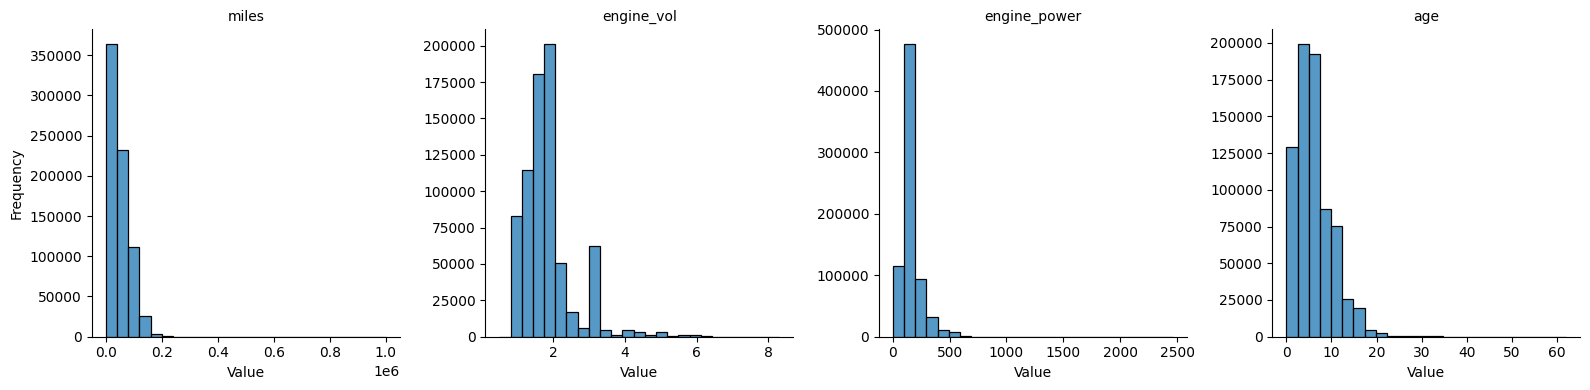

In [323]:
# Define numerical cols
numerical_cols = ['miles', 'engine_vol', 'engine_power', 'age']

# Melt the DataFrame to long format
melted_X_train = clean[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

In [324]:
# Define function to apply log transform
def sqrt_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_sqrt = sqrt_of_feature(clean, numerical_cols)

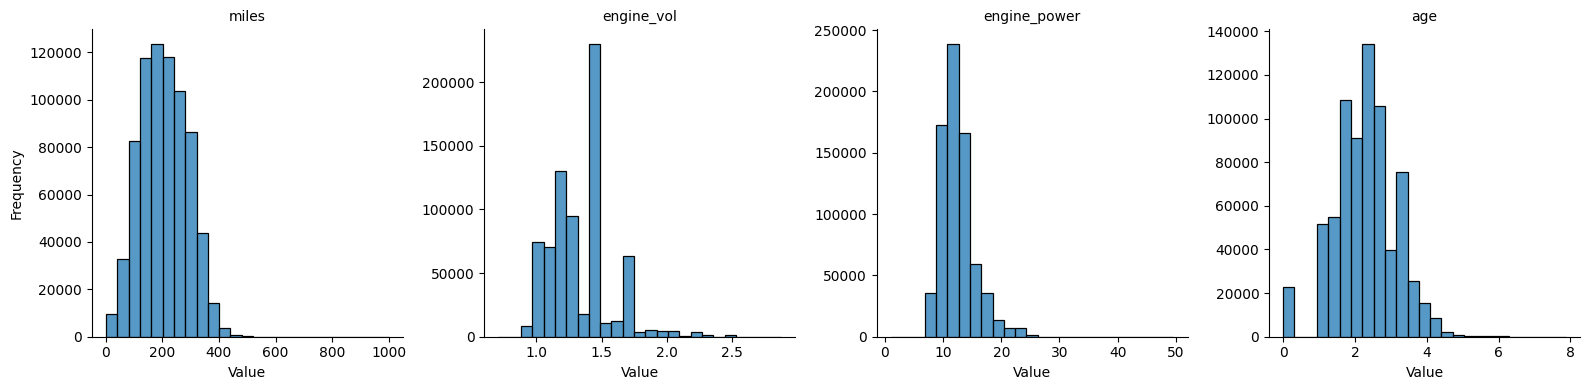

In [325]:
melted_X_train = X_train_cleaned_sqrt[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

In [326]:
# Create X and y sets
X = clean.copy()
y = clean['car_price']

# Drop target feature from X
X.drop(columns=['car_price'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [327]:
# Define binary features
binary_features = ['transmission','ulez', 'full_service', 'part_service', 'private_sale']

# Define target encoding features
target_features = ['make', 'model', 'variant', ]

# Define one-hot features
one_hot_features = ['body_type', 'feul_type']

# Define numeric features for scaling
numeric_features = ['age','miles', 'engine_vol', 'engine_power']

In [328]:
from sklearn.decomposition import PCA

# Define numerical pipeline
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

# Hashing Encoding
pca_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse_output=True, drop='first')),
    ('pca', PCA(n_components=10, svd_solver='arpack'))
])

# Define one-hot pipeline
one_hot_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse_output=True, drop='first'))
])

# Define binary pipeline
binary_pipeline = Pipeline([
    ('binary_encoder', OrdinalEncoder())
])

preprocess_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numeric_features),
    ('pca', pca_pipeline, target_features),
    ('one_hot', one_hot_pipeline, one_hot_features),
    ('binary', binary_pipeline, binary_features)
])

In [329]:
# Transform X train using the pipeline
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

In [330]:
# Create df from process data
X_train_prepared_df = pd.DataFrame(X_train_prepared)

In [331]:
# Update column names
X_train_prepared_df.columns = preprocess_pipeline.get_feature_names_out()

In [332]:
X_train_prepared_df.head()

,numerical__age,numerical__miles,numerical__engine_vol,numerical__engine_power,pca__pca0,pca__pca1,pca__pca2,pca__pca3,pca__pca4,pca__pca5,pca__pca6,pca__pca7,pca__pca8,pca__pca9,one_hot__body_type_car derived van,one_hot__body_type_combi van,one_hot__body_type_convertible,one_hot__body_type_coupe,one_hot__body_type_estate,one_hot__body_type_hatchback,one_hot__body_type_limousine,one_hot__body_type_minibus,one_hot__body_type_mpv,one_hot__body_type_panel van,one_hot__body_type_pickup,one_hot__body_type_pickup double cab car,one_hot__body_type_saloon,one_hot__body_type_suv,one_hot__feul_type_diesel,one_hot__feul_type_diesel hybrid,one_hot__feul_type_diesel plug-in hybrid,one_hot__feul_type_electric,one_hot__feul_type_petrol,one_hot__feul_type_petrol hybrid,one_hot__feul_type_petrol plug-in hybrid,binary__transmission,binary__ulez,binary__full_service,binary__part_service,binary__private_sale
0,-1.205803,-1.093572,-1.185333,-1.035990,-0.178184,-0.195699,-0.386138,0.741084,-0.442653,-0.158924,-0.090023,0.119297,0.036129,0.051965,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.496464,0.000047,0.211576,0.172422,-0.175145,-0.190117,-0.376678,0.721822,-0.430149,-0.152284,-0.087083,0.114470,0.039129,0.059620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.198731,1.012165,-0.626569,-0.913928,-0.156735,-0.085055,-0.061747,0.082642,0.891996,-0.699014,-0.209403,0.209161,0.034922,0.034251,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.253283,1.116676,0.211576,-0.315825,-0.090298,-0.043229,-0.064723,-0.033674,0.031989,0.054157,0.056946,-0.178343,-0.117401,-0.242194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.253283,0.341148,0.211576,-0.035083,-0.073558,-0.018804,-0.015575,0.009318,0.062013,0.066951,0.056749,-0.137729,-0.042871,-0.045051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [333]:
y_train_df = pd.DataFrame(y_train)
y_train_df.columns = ['price']

In [334]:
from sklearn.preprocessing import FunctionTransformer

# Define the forward and inverse transformations
log_transformer = FunctionTransformer(
    func=np.log1p,  # Forward transformation
    inverse_func=np.expm1  # Inverse transformation
)

target_pipeline = Pipeline([
    ('log', log_transformer),
    #('scaler', StandardScaler())
])

y_train_prepared = target_pipeline.fit_transform(y_train_df)

In [335]:
y_train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589862 entries, 770249 to 134531
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   price   589862 non-null  float64
dtypes: float64(1)
memory usage: 9.0 MB


In [336]:
y_untransform_test = target_pipeline.inverse_transform(y_train_prepared)

In [337]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBRegressor', XGBRegressor(random_state=42)),
    ('CatBoostRegressor', CatBoostRegressor(random_state=42, silent=True)),
    ('LightGBMRegressor', LGBMRegressor(random_state=42))
]

In [338]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

In [339]:
y_train_prepared.shape

(589862, 1)

In [340]:
y_train_prepared = y_train_prepared.values.ravel()

In [341]:
y_train_prepared.shape

(589862,)

In [342]:
# Define the custom RMSE function
def custom_rmse(y_true, y_pred, pipeline):
    y_true_inv = pipeline.inverse_transform(y_true.reshape(-1, 1))
    y_pred_inv = pipeline.inverse_transform(y_pred.reshape(-1, 1))
    return np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))

# Create the custom scorer
custom_rmse_scorer = make_scorer(custom_rmse, pipeline=target_pipeline, greater_is_better=False)

In [343]:
# Initialize a dictionary to store the results
reg_results = {}

# Evaluate each regressor using cross-validation
for reg_name, reg in regs:
    print(reg_name)
    cv_rmses = cross_val_score(reg, X_train_prepared, y_train_prepared, cv=reg_kf, scoring=custom_rmse_scorer, n_jobs=-1)
    reg_results[reg_name] = -cv_rmses  # Since the scorer returns negative RMSE

# Convert the results to a DataFrame
reg_cv_scores_df = pd.DataFrame(reg_results)

Linear Regression


Python(11675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11685) Malloc

SGD Regressor
Decision Tree Regression
Random Forest
Gradient Boosting


Python(11756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


XGBRegressor
CatBoostRegressor
LightGBMRegressor


Python(11794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 471889, number of used features: 37
[LightGBM] [Info] Start training from score 9.511223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3214
[LightGBM] [Info] Number of data points in the train set: 471889, number of used features: 38
[LightGBM] [Info] Start training from score 9.511027
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

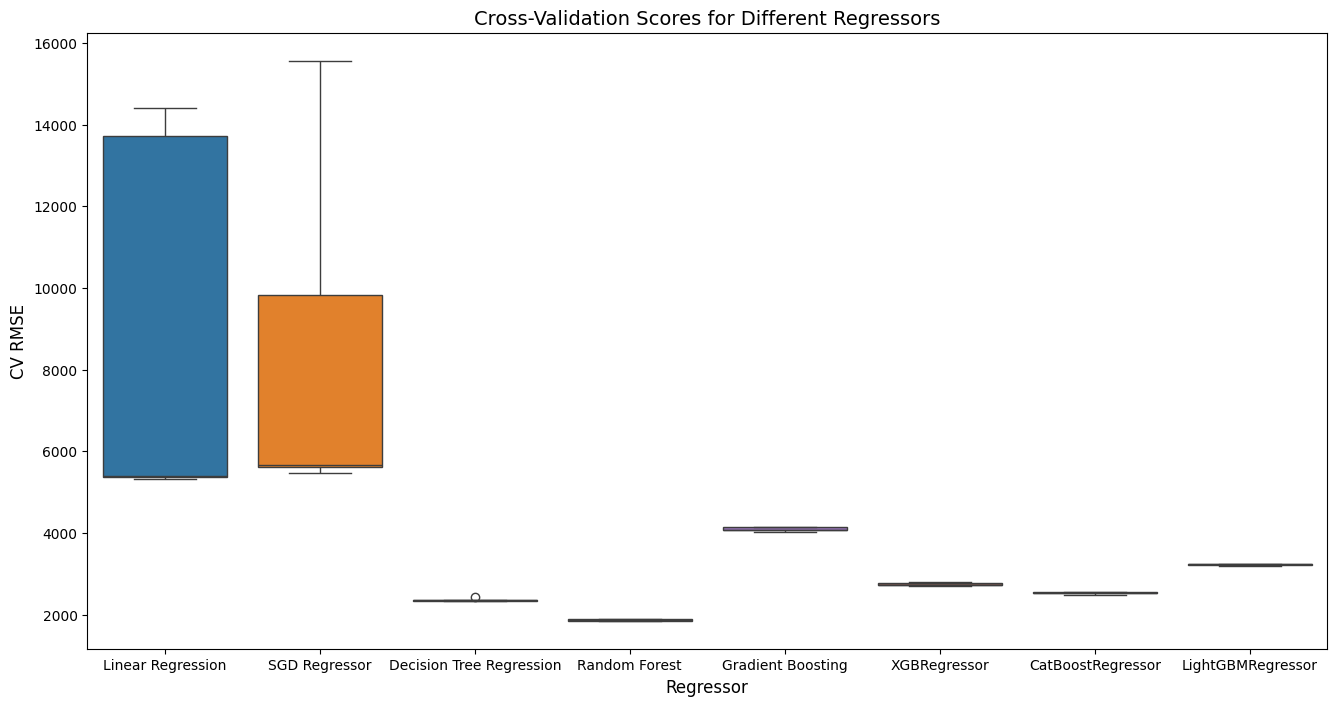

In [354]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

In [345]:
reg_results

{'Linear Regression': array([14410.70658829,  5382.47285835,  5320.61246234,  5367.77626343,
        13721.49178859]),
 'SGD Regressor': array([15565.4813843 ,  5459.64465695,  5665.64497824,  5624.1120525 ,
         9836.01394373]),
 'Decision Tree Regression': array([2351.53870394, 2423.27582089, 2339.08022883, 2353.40848216,
        2323.60654453]),
 'Random Forest': array([1867.62863748, 1898.83792171, 1848.49725392, 1878.02152349,
        1847.65922392]),
 'Gradient Boosting': array([4078.01635197, 4149.83974102, 4062.294879  , 4136.33935686,
        4026.0065202 ]),
 'XGBRegressor': array([2769.5238022 , 2801.1465096 , 2706.61625489, 2727.75173842,
        2726.62923569]),
 'CatBoostRegressor': array([2534.95124302, 2552.03830727, 2515.23969916, 2559.37755088,
        2487.19355958]),
 'LightGBMRegressor': array([3201.65866253, 3241.55628542, 3238.64627322, 3232.90287437,
        3195.49443924])}

In [356]:
reg_results_2 = {key:value for key, value in reg_results.items() if key not in ['Linear Regression', 'SGD Regressor']}

reg_results_2_df = pd.DataFrame(reg_results_2)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

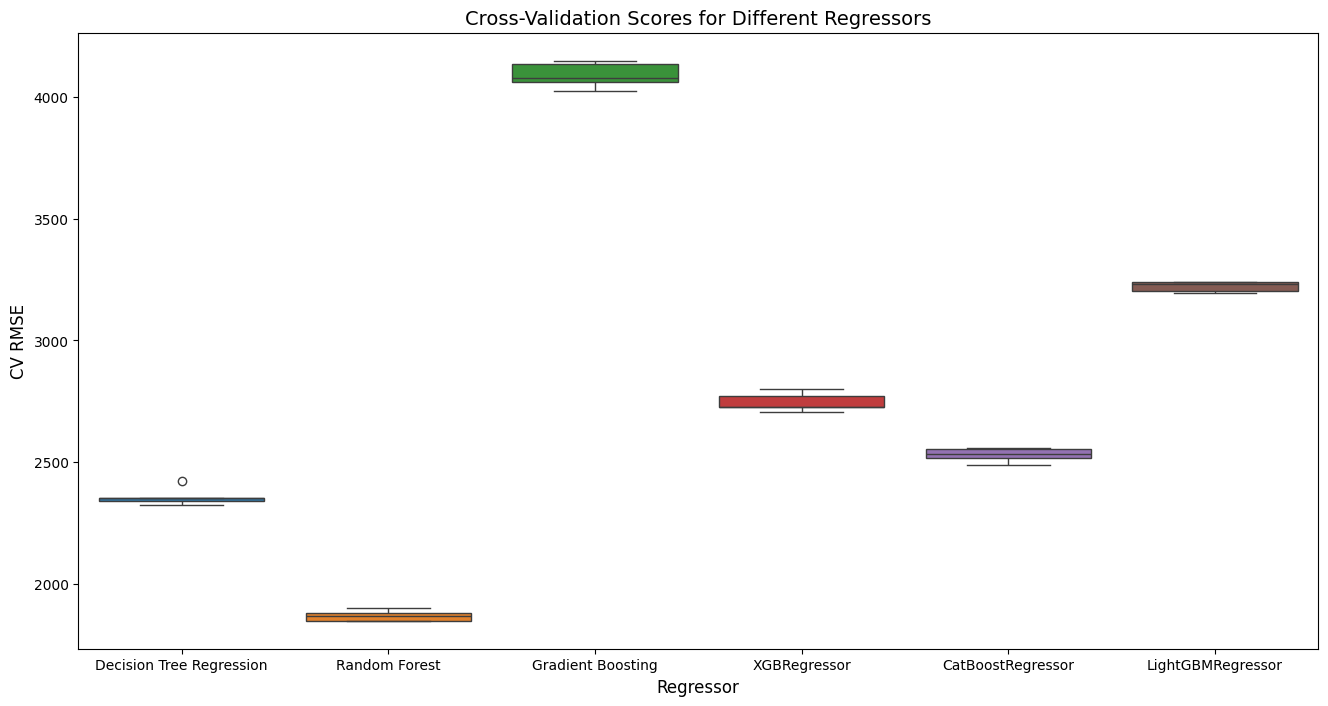

In [357]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_results_2_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

In [365]:
# Sample 20% of the data
# Ensure y_train is a pandas Series
y_train_series = pd.Series(y_train_prepared).reset_index(drop=True)

X_sampled = X_train_prepared_df.sample(frac=0.15, random_state=42)
y_sampled = y_train_series[X_sampled.index]

# Split the data into training and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [368]:
import optuna

def custom_rmse2(y_true, y_pred, pipeline):
    y_true_inv = pipeline.inverse_transform(y_true.to_numpy().reshape(-1, 1))
    y_pred_inv = pipeline.inverse_transform(y_pred.reshape(-1, 1))
    return np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    # Create the model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    
    # Train the model
    rf.fit(X_sampled, y_sampled)
    
    # Predict on the validation set
    y_pred = rf.predict(X_val)
    
    # Calculate the RMSE
    rmse = custom_rmse2(y_val, y_pred, target_pipeline)
    
    return rmse

In [369]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=20, show_progress_bar=True, n_jobs=-1)

[I 2024-08-08 11:55:51,846] A new study created in memory with name: no-name-9bf8f0d9-ec34-4c78-aa45-dc7d13c70719
Best trial: 0. Best value: 1619.78:  10%|█         | 2/20 [03:04<24:09, 80.54s/it] 

[I 2024-08-08 11:58:56,077] Trial 9 finished with value: 2563.8327772863486 and parameters: {'n_estimators': 52, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 0 with value: 1619.7802996352898.


Best trial: 11. Best value: 1589.34:  15%|█▌        | 3/20 [04:12<21:12, 74.87s/it]

[I 2024-08-08 12:00:03,101] Trial 11 finished with value: 1589.3395349154841 and parameters: {'n_estimators': 85, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 1589.3395349154841.


Best trial: 11. Best value: 1589.34:  20%|██        | 4/20 [04:24<13:20, 50.02s/it]

[I 2024-08-08 12:00:16,104] Trial 8 finished with value: 2326.3349269167657 and parameters: {'n_estimators': 115, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 11 with value: 1589.3395349154841.


Best trial: 1. Best value: 1012.9:  30%|███       | 6/20 [06:39<15:30, 66.45s/it]

[I 2024-08-08 12:02:31,263] Trial 10 finished with value: 2221.2381167208323 and parameters: {'n_estimators': 186, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 1 with value: 1012.9035129881916.


Best trial: 1. Best value: 1012.9:  45%|████▌     | 9/20 [07:11<05:03, 27.55s/it]

[I 2024-08-08 12:03:03,546] Trial 6 finished with value: 3174.5832053807135 and parameters: {'n_estimators': 182, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 1 with value: 1012.9035129881916.


Best trial: 1. Best value: 1012.9:  50%|█████     | 10/20 [07:15<03:21, 20.11s/it]

[I 2024-08-08 12:03:07,005] Trial 14 finished with value: 1836.657143130961 and parameters: {'n_estimators': 85, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 1012.9035129881916.


Best trial: 1. Best value: 1012.9:  60%|██████    | 12/20 [07:31<01:53, 14.18s/it]

[I 2024-08-08 12:03:22,862] Trial 13 finished with value: 2494.6058206601533 and parameters: {'n_estimators': 97, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 1 with value: 1012.9035129881916.


Best trial: 1. Best value: 1012.9:  70%|███████   | 14/20 [07:55<01:21, 13.62s/it]

[I 2024-08-08 12:03:47,529] Trial 15 finished with value: 2490.964689459767 and parameters: {'n_estimators': 142, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 1 with value: 1012.9035129881916.


Best trial: 1. Best value: 1012.9:  95%|█████████▌| 19/20 [09:34<00:18, 18.78s/it]

[I 2024-08-08 12:05:26,243] Trial 7 finished with value: 1395.2764514238681 and parameters: {'n_estimators': 300, 'max_depth': 39, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 1012.9035129881916.


Best trial: 1. Best value: 1012.9: 100%|██████████| 20/20 [09:45<00:00, 29.26s/it]

[I 2024-08-08 12:05:37,004] Trial 17 finished with value: 2165.7702041445614 and parameters: {'n_estimators': 289, 'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 1 with value: 1012.9035129881916.


In [370]:
best_params = study.best_params
print(best_params)

{'n_estimators': 80, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}


In [371]:
print(study.best_value)

1012.9035129881916


In [375]:
# Create the model with the best hyperparameters
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42,
    n_jobs=-1
)

# Cross-validate the model using the whole training set
cv_rmse_scores = cross_val_score(best_rf, X_train_prepared, y_train_prepared, cv=5, scoring=custom_rmse_scorer, n_jobs=-1)

# Calculate the mean and standard deviation of RMSE scores
mean_rmse = -cv_rmse_scores.mean()
std_rmse = cv_rmse_scores.std()

Python(12610) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [376]:
mean_rmse

1882.5751618043328

In [377]:
# Create nested dictionary
nested_dict = {}
for i, row in clean.iterrows():
    make = row['make']
    model = row['model']
    variant = row['variant']
    body_type = row['body_type']
    engine_vol = row['engine_vol']
    transmission = row['transmission']
    feul_type = row['feul_type']
    ulez = row['ulez']
    engine_power = row['engine_power']

    (nested_dict
     .setdefault(make, {})
     .setdefault(model, {})
     .setdefault(variant, {})
     .setdefault(body_type, {})
     .setdefault(engine_vol, {})
     .setdefault(transmission, {})
     .setdefault(feul_type, {})
     .setdefault(ulez, {})
     .setdefault(engine_power, {})
    )

In [380]:
import json

# Save to a JSON file
with open('car_data.json', 'w') as json_file:
    json.dump(nested_dict, json_file, indent=4)